# Preprocess Video Frames Script

This script performs the following steps:
  1. Iterates over each .avi file in the input directory.
  2. Loads the video frames (extracting one frame per second).
  3. Crops each frame to the region of interest and applies CLAHE enhancement.
  4. Saves the processed frames to an output directory (organized by video filename).

Requirements:
  - OpenCV
  - os
  - numpy
  - Python 3.x

### Import

In [1]:
import os
import cv2
import numpy as np

### Define input and output paths

In [2]:
video_path = 'C:/Users/linus/NematodeAI/0_Data/Videos/2025.03.24_gemischte Stadien aus Fermenterlauf D31220_Tag 11/1zu100/C0134.MP4'   # Replace with your video p
output_dir =  'linus/NematodeAI/0_Data/Frames'  # Output directory for processed frames
FRAMES = 4  # Number of frames to extract per second

### Helper Functions

In [44]:
def preprocess_frame(frame, clahe):
    """
    Convert the frame to grayscale, apply CLAHE, and convert back to 3-channel.
    """
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    enhanced_frame = clahe.apply(gray_frame)
    return cv2.cvtColor(enhanced_frame, cv2.COLOR_GRAY2BGR)

def load_video_frames(video_path):
    """
    Load video frames into a list of numpy arrays.
    Extracts one frame per second.
    """

    if not os.path.exists(video_path):
        print(f"Error: File does not exist at {video_path}")
    
    cap = cv2.VideoCapture(str(video_path))
        # Check if video opened successfully
    if not cap.isOpened():
        print(f"Error: Could not open video file: {video_path}")
        return []
                               
    frame_interval = 1             # One frame per second
    frame_count = 0
    frames = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % frame_interval == 0:
            frames.append(frame)
        frame_count += 1

    cap.release()
    return frames

def watershed (img):
    """""
    Apply watershed algorithm to an image.
    """""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # noise removal
    kernel = np.ones((2,2), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    # sure background area
    sure_bg = cv2.dilate(opening, kernel, iterations=5)
    return sure_bg

def houghCircle (img, param1, param2, minRadius, maxRadius):
    """"
    Apply Hough Circle Transform to an image. Returns array of circles detected [centerx, centery, radius].
    """""
    circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1,20,
                            param1=40,param2=20,minRadius=900,maxRadius=1030)
    return circles

def crop_image(img, x, y, r, tolerance):
    """
    Crop the image to the specified region of interest.
    """

    r = r + tolerance
    cropImage = img[y-r:y+r, x-r:x+r]
    return cropImage

def mask_image(img, r):
    """
    Apply mask to an image according to the circle detected.
    """
    mask = np.zeros_like(img)
    cv2.circle(mask, (mask.shape[1]//2, mask.shape[0]//2), r, (255, 255, 255), -1)
    masked_img = cv2.bitwise_and(img, mask)
    return masked_img

def clahe(img):
    """
    Apply Contrast Limited Adaptive Histogram Equalization (CLAHE) to an image.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(gray)
    return img

### Main 

Processing video: C:/Users/linus/NematodeAI/0_Data/Videos/2025.03.24_gemischte Stadien aus Fermenterlauf D31220_Tag 11/1zu100/C0134.MP4


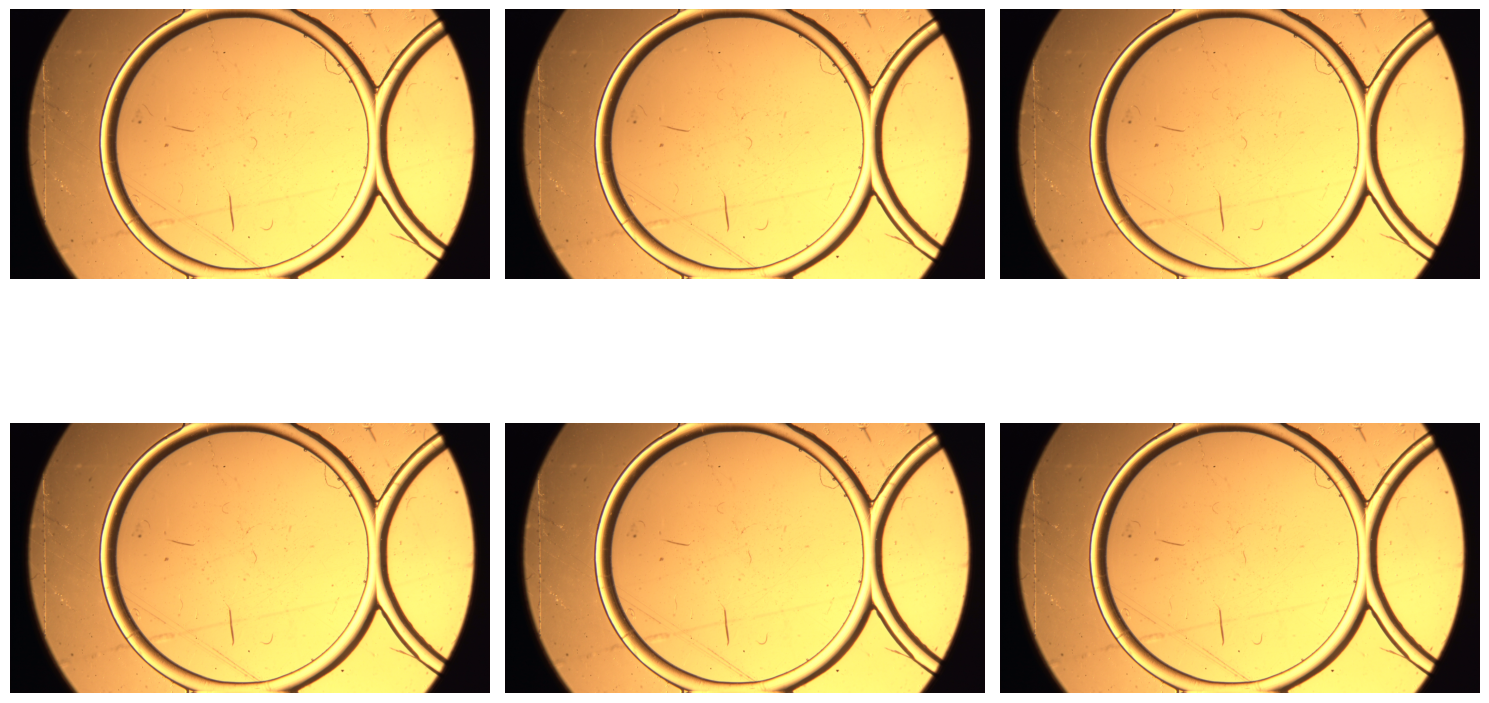

In [49]:
os.makedirs(output_dir, exist_ok=True)
        
print(f"Processing video: {video_path}")

# Load frames (FRAMES per second)
frames = load_video_frames(video_path)
if not frames:
    print(f"WARNING: No frames extracted from video.")
    exit(1)

# Display the extracted frames side by side
import matplotlib.pyplot as plt

# Display 6 extracted frames in a 2x3 grid
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for idx, ax in enumerate(axes.flat):
    if idx < len(frames):
        ax.imshow(cv2.cvtColor(frames[idx], cv2.COLOR_BGR2RGB))
        ax.axis('off')
    else:
        ax.axis('off')  # Hide unused subplots
plt.tight_layout()
plt.show()

In [9]:
# Create output directory using video filename
base_name = os.path.splitext(os.path.basename(video_path))[0]
video_output_dir = os.path.join(output_dir, base_name)
os.makedirs(video_output_dir, exist_ok=True)

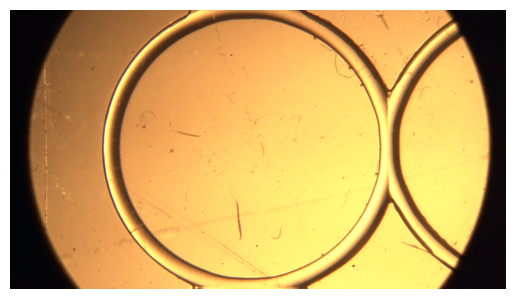

In [50]:
plt.imshow(cv2.cvtColor(frames[5], cv2.COLOR_BGR2RGB))
plt.axis('off')  # Hide axes for better visualization
plt.show()

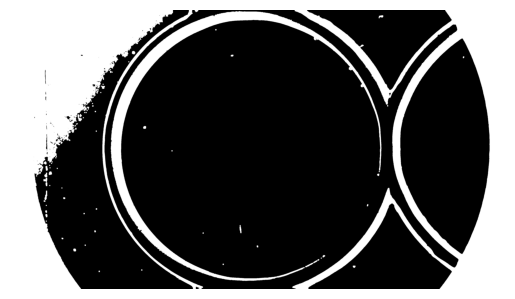

In [51]:
watershed_img = watershed(frames[5])
plt.imshow(cv2.cvtColor(watershed_img, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Hide axes for better visualization
plt.show()

Circle detected in image
Circle center: (1760, 1068), radius: 1029


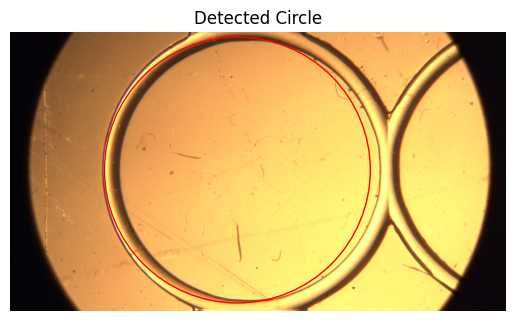

In [52]:
circles = houghCircle(watershed_img, 40, 20, 990, 1030)
if circles is not None:
    print(f"Circle detected in image")
    circles = np.uint16(np.around(circles))
    max_circle = max(circles[0, :], key=lambda x: x[2])
    x, y, r = max_circle

print(f"Circle center: ({x}, {y}), radius: {r}")

# Display the frame with the circle
plt.imshow(cv2.cvtColor(frames[5], cv2.COLOR_BGR2RGB))
plt.gca().add_patch(plt.Circle((x, y), r, color='r', fill=False))
plt.title("Detected Circle")
plt.axis('off')  # Hide axes for better visualization
plt.show()

In [23]:
cropped_img = crop_image(frames[5], x, y, r, 10)
plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
plt.axis('off') 

C:\Users\linus\AppData\Local\Temp\ipykernel_19780\3076854144.py:70: RuntimeWarning: overflow encountered in scalar subtract
  y1 = max(y - r, 0)


error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [11]:
# Save each processed frame as an image file
for idx, frame in enumerate(frames):
    output_filename = f"{base_name}_frame_{idx}.jpg"
    output_path = os.path.join(video_output_dir, output_filename)
    print(f"Processing frame {idx + 1}/{len(frames)}: {output_filename}")

    # Apply preprocessing steps

    # Apply watershed algorithm
    watershed_img = watershed(frame)
    # Apply Hough Circle Transform
    circles = houghCircle(watershed_img, 40, 20, 990, 1030)
    
    if circles is not None:
        print(f"Circle detected in {output_filename}")
        circles = np.uint16(np.around(circles))
        max_circle = max(circles[0, :], key=lambda x: x[2])
        x, y, r = max_circle
        # Crop the image to the region of interest
        cropped_img = crop_image(watershed_img, x, y, r, 10)
        # masked_image = mask_image(cropped_img, r)
        # masked_image = clahe(masked_image)
        # Save the processed image
        cv2.imwrite(output_path, cropped_img)
        print(f"Saved preprocessed frame: {output_path}")
    else:
        print(f"No circles detected in {output_filename}")  
        

Processing frame 1/240: C0134_frame_0.jpg
Circle detected in C0134_frame_0.jpg


C:\Users\linus\AppData\Local\Temp\ipykernel_19780\3661293631.py:70: RuntimeWarning: overflow encountered in scalar subtract
  y1 = max(y - r, 0)


error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:929: error: (-215:Assertion failed) !_img.empty() in function 'cv::imwrite'
